In [2]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from statsmodels.robust.scale import huber
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import re
import locale
import geopandas
plt.style.use('seaborn')
%matplotlib inline

pd.set_option('display.max_rows', 0)
pd.set_option('display.max_columns', 0)


# df_indicadores_pob = pd.read_parquet(f'../data/processed/df_indicadores_pob.parquet')
# df_final_pob = pd.read_parquet('../data/processed/df_final_pob.parquet')
# df_final_pob_melt = pd.read_parquet('../data/processed/df_final_pob_melt.parquet')
# df_final_pob_melt_PC = pd.read_parquet('../data/processed/df_final_pob_melt_PC.parquet')
# CCAA_CO = pd.read_parquet('../data/processed/CCAA_CO.parquet')
# MUNI_CO = pd.read_parquet('../data/processed/MUNI_CO.parquet')
# PROV_CO = pd.read_parquet('../data/processed/PROV_CO.parquet')



In [3]:
df_final_pob=pd.read_parquet('../data/main_processed/df_final_pob.parquet')

df_indicadores_pob=pd.read_parquet('../data/main_processed/df_indicadores_pob.parquet')

df_indicadores_pob_pivot=pd.read_parquet('../data/main_processed/df_indicadores_pob_pivot.parquet')

df_final_pob_melt=pd.read_parquet('../data/main_processed/df_final_pob_melt.parquet')

df_final_pob_melt_PC=pd.read_parquet('../data/main_processed/df_final_pob_melt_PC.parquet')

CCAA_CO = pd.read_parquet('../data/main_processed/CCAA_CO.parquet')
MUNI_CO = pd.read_parquet('../data/main_processed/MUNI_CO.parquet')
PROV_CO = pd.read_parquet('../data/main_processed/PROV_CO.parquet')

df_final_pob_dropdown=pd.read_parquet('../data/main_processed/df_final_pob_dropdown.parquet')

df_final_pob_dropdown_c=pd.read_parquet('../data/main_processed/df_final_pob_dropdown_c.parquet')

df_final_pob_poblaciontext=pd.read_parquet('../data/main_processed/df_final_pob_poblaciontext.parquet')


# %%timeit

In [4]:
CCAA_types='Andalucía'
municipio_types= 'Sevilla'
cohorte='1.000-2.000'
partida_de_coste_types='Abastecimiento de agua potable'

In [5]:
cols = df_final_pob.columns.tolist()
cols = cols[3:48] + cols[49:51]

df_final_pob2=df_final_pob[cols]
df_final_pob2=df_final_pob2.drop(columns=['Código Ente Principal','Nombre Ente Principal'])


In [6]:
df_final_pob2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4869 entries, 0 to 4868
Data columns (total 45 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Abastecimiento de agua potable                                                    4869 non-null   float64
 1   Abastos, mercados, lonjas                                                         4869 non-null   float64
 2   Acceso a los núcleos de población                                                 4869 non-null   float64
 3   Actividades funerarias                                                            4869 non-null   float64
 4   Alcantarillado                                                                    4869 non-null   float64
 5   Alumbrado público                                                                 4869 non-null   float64
 6   

In [7]:
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_rescaled = scaler.fit_transform(df_final_pob)

rs = StandardScaler()
data_rescaled  = pd.DataFrame(rs.fit_transform(df_final_pob2), columns= df_final_pob2.columns)

#data_rescaled

In [8]:
import umap

reducer = umap.UMAP(random_state=42,
                    n_neighbors=15,
                    min_dist=0.1,
                    n_components=2,
                    metric='euclidean')
reducer.fit(data_rescaled)

embedding = reducer.transform(data_rescaled)

embedding.shape



(4869, 2)

In [9]:
import hdbscan

hdbscan_c = hdbscan.HDBSCAN(min_cluster_size=300)

hdbscan_c.fit(embedding)

hdbscan_c

HDBSCAN(min_cluster_size=300)

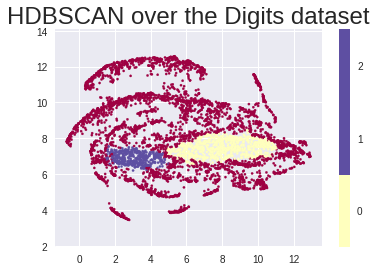

In [10]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=hdbscan_c.labels_, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(len(np.unique(hdbscan_c.labels_)) + 1) - 0.5).set_ticks(np.arange(len(np.unique(hdbscan_c.labels_))))
plt.title('HDBSCAN over the Digits dataset', fontsize=24);

In [11]:
from sklearn.cluster import DBSCAN

dbscan_c = DBSCAN(eps=2, min_samples=600).fit(embedding)

dbscan_c

DBSCAN(eps=2, min_samples=600)

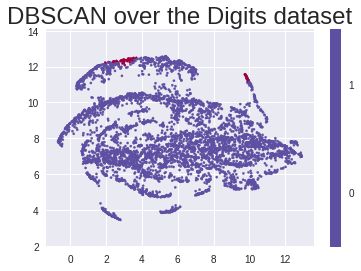

In [12]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=dbscan_c.labels_, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(len(np.unique(dbscan_c.labels_)) + 1) - 0.5).set_ticks(np.arange(len(np.unique(dbscan_c.labels_))))
plt.title('DBSCAN over the Digits dataset', fontsize=24);

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42).fit(embedding)

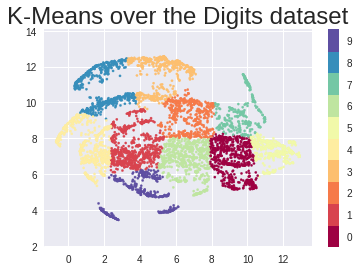

In [14]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans.labels_, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(kmeans.n_clusters + 1) - 0.5).set_ticks(np.arange(kmeans.n_clusters))
plt.title('K-Means over the Digits dataset', fontsize=24);

In [15]:
df_final_pob['cluster']=kmeans.labels_

In [16]:
df_final_pob['cluster'].value_counts()

0    625
1    623
6    617
4    538
8    492
2    463
3    443
5    401
9    368
7    299
Name: cluster, dtype: int64

In [17]:
cols = df_final_pob.columns.tolist()
cols = cols[0:5] + cols[49:]

df_final_pob3=df_final_pob[cols]

df_final_pob3=df_final_pob3.drop(columns=['codigo_geo'])

cols = df_final_pob3.columns.tolist()
cols4 = cols[0:7] + cols[50:] + cols[8:18]
cols5= cols[0:7] + cols[50:] + cols[18:28]
cols6= cols[0:7] + cols[50:] + cols[28:38]
cols7= cols[0:7] + cols[50:] + cols[38:50]


df_final_pob4=df_final_pob3[cols4]
df_final_pob5=df_final_pob3[cols5]
df_final_pob6=df_final_pob3[cols6]
df_final_pob7=df_final_pob3[cols7]


df_final_pob4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4869 entries, 0 to 4868
Data columns (total 20 columns):
 #   Column                                                                               Non-Null Count  Dtype   
---  ------                                                                               --------------  -----   
 0   CCAA                                                                                 4869 non-null   category
 1   Provincia                                                                            4869 non-null   category
 2   Tipo Ente Principal                                                                  4869 non-null   category
 3   Nombre Ente Principal                                                                4869 non-null   category
 4   Código Ente Principal                                                                4869 non-null   category
 5   Población 2018                                                                     

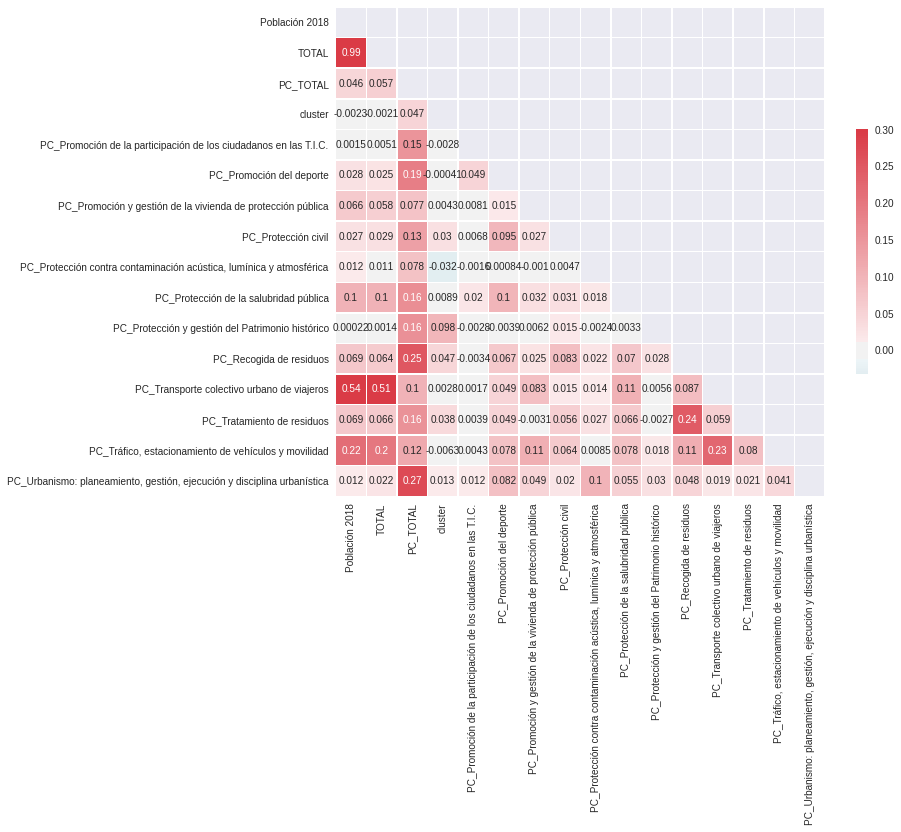

In [18]:
df=df_final_pob7
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

In [49]:
df_final_pob[['Población 2018','PC_TOTAL', 'cohorte_pob','cluster']]

df=df_final_pob[['Población 2018','PC_TOTAL', 'cohorte_pob','cluster']].loc[df_final_pob['Población 2018']<10000]
df['cluster'] = df['cluster'].astype('category')

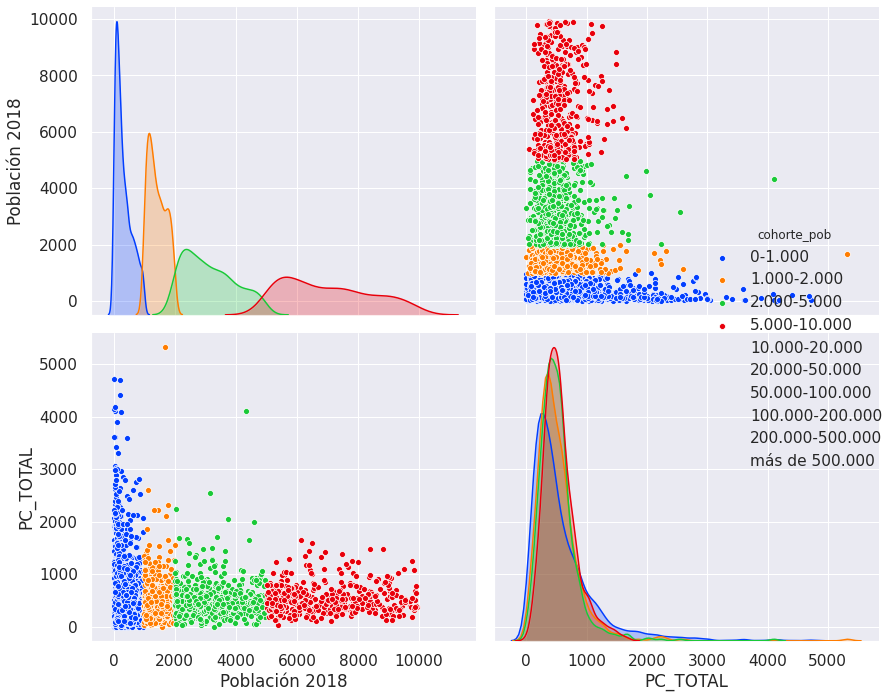

In [50]:




# sns.set(font_scale=1.4)
sns.pairplot(df[['Población 2018','PC_TOTAL', 'cohorte_pob']],hue='cohorte_pob',height=5,palette='bright', diag_kind='kde')
plt.tight_layout()
plt.show()

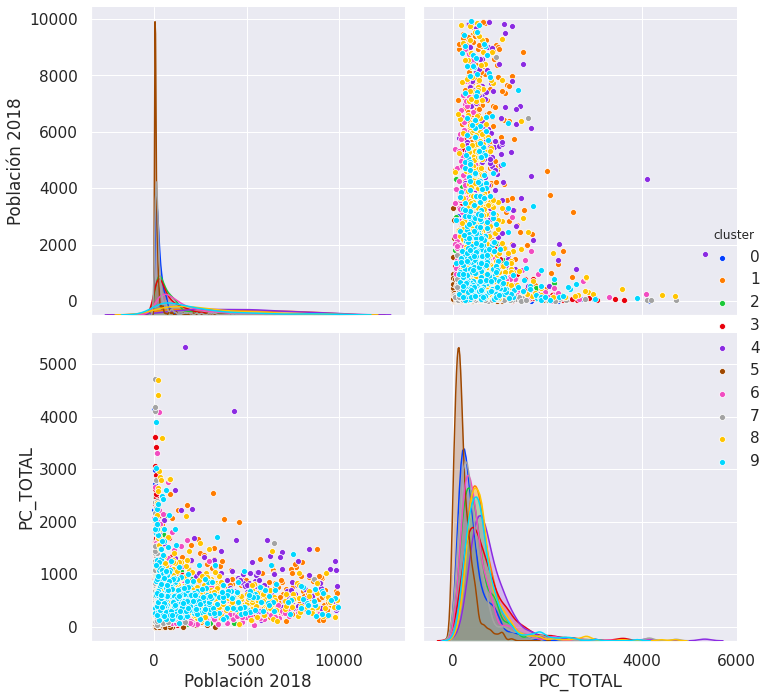

In [51]:
sns.pairplot(df[['Población 2018','PC_TOTAL', 'cluster']],hue='cluster',height=5,palette='bright', diag_kind='kde')
plt.tight_layout()
plt.show()